In [304]:
# Import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
plt.style.use('seaborn')

%matplotlib inline

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()
import plotly.express as px

pd.set_option('display.max_columns', None)

import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression

In [318]:
data = pd.read_csv('Data/df_cleaned.csv')
data.head()

newlyConst  balcony  totalRent  hasKitchen  cellar  livingSpace  lift  \
0           0        0     955.00           0       0        62.63     0   
1           1        1    1300.00           1       1        46.40     1   
2           0        1    1428.78           1       1        67.00     1   
3           1        1    1559.05           1       1        73.54     1   
4           0        1    1280.00           1       1        83.14     0   

     typeOfFlat  geo_plz  noRooms  garden      regio3   date  buildingAge  \
0  ground_floor    13086      2.0       0   Weißensee  Oct19        102.0   
1     apartment    10179      2.0       0       Mitte  Oct19          1.0   
2     apartment    10963      2.5       0   Kreuzberg  Oct19          3.0   
3  ground_floor    10557      2.0       0  Tiergarten  Feb20          1.0   
4     apartment    12527      3.0       0    Köpenick  Oct19          6.0   

   schufa_yn  PersonalInfo_yn  incomeProof_yn  guarantee_yn  debtFreeProof_yn  \
0          0                0               0             0                 0   
1          0                0               0             0                 0   
2          0                0               0             0                 0   
3          0                0               0             0                 0   
4          0                0               0             0                 0   

   ID_yn  utilitiesPrice  
0      0          147.00  
1      0          150.00  
2      1          228.78  
3      0          221.05  
4      0          232.00

## Normalization
From EDA we found that totalRent is not normally distributed. I will now use the log transformation to fix this

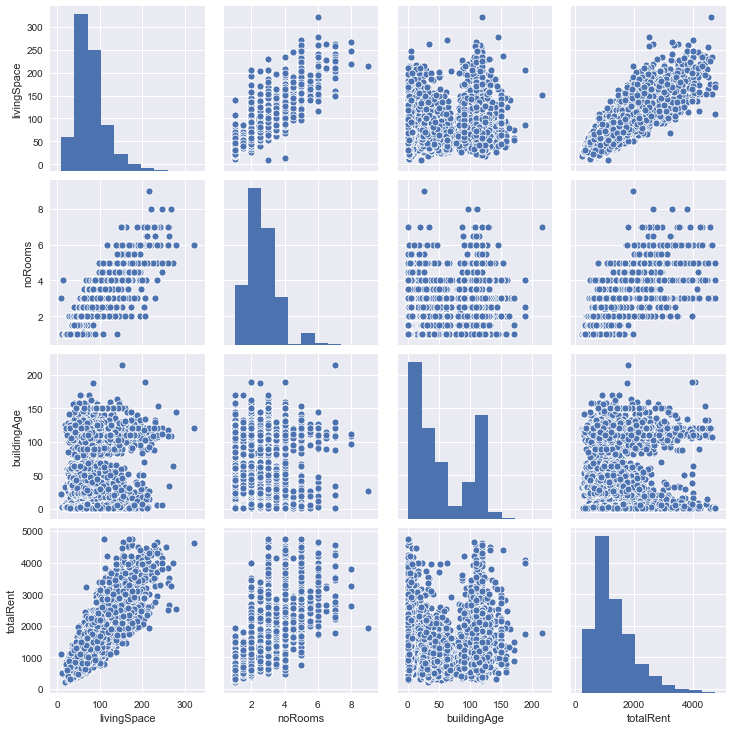

In [319]:
sns.pairplot(data[['livingSpace','noRooms','buildingAge','totalRent']])

In [320]:
log_rent = np.log(data['totalRent'])
data['log_rent'] = log_rent
data.head()

newlyConst  balcony  totalRent  hasKitchen  cellar  livingSpace  lift  \
0           0        0     955.00           0       0        62.63     0   
1           1        1    1300.00           1       1        46.40     1   
2           0        1    1428.78           1       1        67.00     1   
3           1        1    1559.05           1       1        73.54     1   
4           0        1    1280.00           1       1        83.14     0   

     typeOfFlat  geo_plz  noRooms  garden      regio3   date  buildingAge  \
0  ground_floor    13086      2.0       0   Weißensee  Oct19        102.0   
1     apartment    10179      2.0       0       Mitte  Oct19          1.0   
2     apartment    10963      2.5       0   Kreuzberg  Oct19          3.0   
3  ground_floor    10557      2.0       0  Tiergarten  Feb20          1.0   
4     apartment    12527      3.0       0    Köpenick  Oct19          6.0   

   schufa_yn  PersonalInfo_yn  incomeProof_yn  guarantee_yn  debtFreeProof_yn  \
0          0                0               0             0                 0   
1          0                0               0             0                 0   
2          0                0               0             0                 0   
3          0                0               0             0                 0   
4          0                0               0             0                 0   

   ID_yn  utilitiesPrice  log_rent  
0      0          147.00  6.861711  
1      0          150.00  7.170120  
2      1          228.78  7.264576  
3      0          221.05  7.351832  
4      0          232.00  7.154615

log_rent = np.log(data['totalRent'])
log_buildingAge = np.log(data['buildingAge'])
log_noRooms = np.log(data['noRooms'])
log_livingSpace = np.log(data['livingSpace'])

data['log_rent'] = log_rent
data['log_buildingAge'] = log_buildingAge
data['log_noRooms'] = log_noRooms
data['log_livingSpace'] = log_livingSpace

data.head()

In [321]:
data.columns

Index(['newlyConst', 'balcony', 'totalRent', 'hasKitchen', 'cellar',
       'livingSpace', 'lift', 'typeOfFlat', 'geo_plz', 'noRooms', 'garden',
       'regio3', 'date', 'buildingAge', 'schufa_yn', 'PersonalInfo_yn',
       'incomeProof_yn', 'guarantee_yn', 'debtFreeProof_yn', 'ID_yn',
       'utilitiesPrice', 'log_rent'],
      dtype='object')

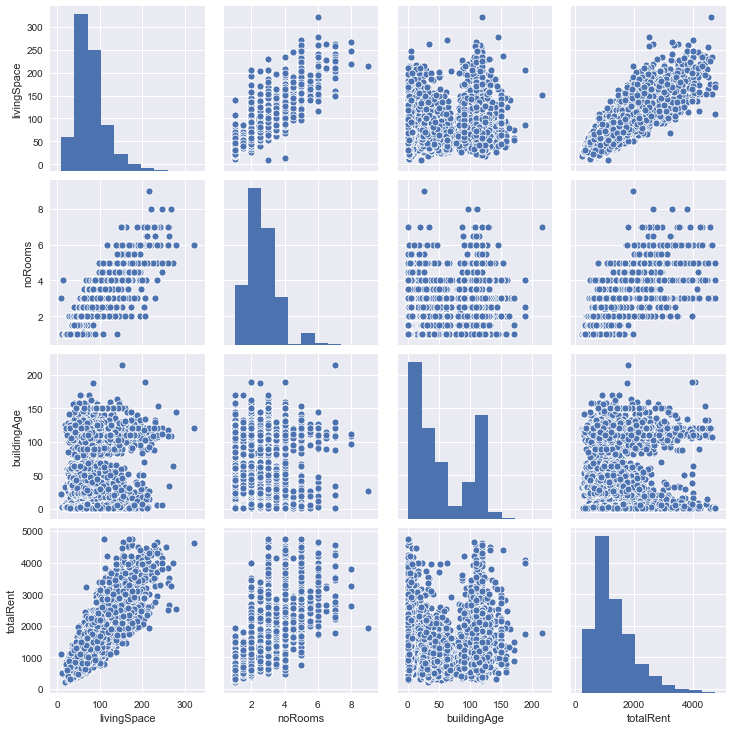

In [322]:
sns.pairplot(data[['livingSpace','noRooms','buildingAge','totalRent']])

## Multicollinearity

In [323]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [324]:
variables = data[['livingSpace','noRooms','buildingAge','newlyConst']]
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif['features'] = variables.columns

In [325]:
vif

VIF     features
0  20.466119  livingSpace
1  20.359961      noRooms
2   2.414359  buildingAge
3   1.506105   newlyConst

As expected, noRooms and livingSpace are too correlated with each other. I will remove noRooms from the data

In [326]:
data.drop('noRooms', axis = 1, inplace = True)

## Create dummy variables

In [327]:
#Including only string columns in a ``DataFrame`` description.
data.describe(include=[np.object])

typeOfFlat      regio3   date
count        8510        8510   8510
unique          9          24      5
top     apartment  Tiergarten  May19
freq         6095         631   2101

In [328]:
data_dumm = pd.get_dummies(data.drop('date', axis = 1), drop_first = False)

#drop regio3_Mitte from dummies so that it can be the benchmark
data_dumm = data_dumm.drop('regio3_Mitte', axis = 1)

#drop typeOfFlat_apartment from dummies so that it can be the benchmark
data_dumm = data_dumm.drop('typeOfFlat_apartment', axis = 1)


In [329]:
data_dumm.head()

newlyConst  balcony  totalRent  hasKitchen  cellar  livingSpace  lift  \
0           0        0     955.00           0       0        62.63     0   
1           1        1    1300.00           1       1        46.40     1   
2           0        1    1428.78           1       1        67.00     1   
3           1        1    1559.05           1       1        73.54     1   
4           0        1    1280.00           1       1        83.14     0   

   geo_plz  garden  buildingAge  schufa_yn  PersonalInfo_yn  incomeProof_yn  \
0    13086       0        102.0          0                0               0   
1    10179       0          1.0          0                0               0   
2    10963       0          3.0          0                0               0   
3    10557       0          1.0          0                0               0   
4    12527       0          6.0          0                0               0   

   guarantee_yn  debtFreeProof_yn  ID_yn  utilitiesPrice  log_rent  \
0             0                 0      0          147.00  6.861711   
1             0                 0      0          150.00  7.170120   
2             0                 0      1          228.78  7.264576   
3             0                 0      0          221.05  7.351832   
4             0                 0      0          232.00  7.154615   

   typeOfFlat_ground_floor  typeOfFlat_half_basement  typeOfFlat_loft  \
0                        1                         0                0   
1                        0                         0                0   
2                        0                         0                0   
3                        1                         0                0   
4                        0                         0                0   

   typeOfFlat_maisonette  typeOfFlat_penthouse  \
0                      0                     0   
1                      0                     0   
2                      0                     0   
3                      0                     0   
4                      0                     0   

   typeOfFlat_raised_ground_floor  typeOfFlat_roof_storey  \
0                               0                       0   
1                               0                       0   
2                               0                       0   
3                               0                       0   
4                               0                       0   

   typeOfFlat_terraced_flat  regio3_Buchholz  regio3_Charlottenburg  \
0                         0                0                      0   
1                         0                0                      0   
2                         0                0                      0   
3                         0                0                      0   
4                         0                0                      0   

   regio3_Friedrichshain  regio3_Hellersdorf  regio3_Hohenschönhausen  \
0                      0                   0                        0   
1                      0                   0                        0   
2                      0                   0                        0   
3                      0                   0                        0   
4                      0                   0                        0   

   regio3_Kreuzberg  regio3_Köpenick  regio3_Lichtenberg  regio3_Marzahn  \
0                 0                0                   0               0   
1                 0                0                   0               0   
2                 1                0                   0               0   
3                 0                0                   0               0   
4                 0                1                   0               0   

   regio3_Neukölln  regio3_Pankow  regio3_Prenzlauer Berg  \
0                0              0                       0   
1                0              0                       0   
2                0              0    

In [330]:
variables = data_dumm.drop(['totalRent','log_rent'], axis = 1)
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif['features'] = variables.columns
vif[vif['VIF'] > 5]

VIF        features
4   18.586629     livingSpace
6   42.945613         geo_plz
15  16.504780  utilitiesPrice

In [331]:
#drop geo_plz and utilitiesPrice
data_dumm = data_dumm.drop(['utilitiesPrice', 'geo_plz'], axis = 1)

In [332]:
variables = data_dumm.drop(['totalRent','log_rent'], axis = 1)
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif['features'] = variables.columns
vif[vif['VIF'] > 5]

VIF     features
4  7.008775  livingSpace

## Rearrange columns

In [333]:
data_dumm.columns

Index(['newlyConst', 'balcony', 'totalRent', 'hasKitchen', 'cellar',
       'livingSpace', 'lift', 'garden', 'buildingAge', 'schufa_yn',
       'PersonalInfo_yn', 'incomeProof_yn', 'guarantee_yn', 'debtFreeProof_yn',
       'ID_yn', 'log_rent', 'typeOfFlat_ground_floor',
       'typeOfFlat_half_basement', 'typeOfFlat_loft', 'typeOfFlat_maisonette',
       'typeOfFlat_penthouse', 'typeOfFlat_raised_ground_floor',
       'typeOfFlat_roof_storey', 'typeOfFlat_terraced_flat', 'regio3_Buchholz',
       'regio3_Charlottenburg', 'regio3_Friedrichshain', 'regio3_Hellersdorf',
       'regio3_Hohenschönhausen', 'regio3_Kreuzberg', 'regio3_Köpenick',
       'regio3_Lichtenberg', 'regio3_Marzahn', 'regio3_Neukölln',
       'regio3_Pankow', 'regio3_Prenzlauer Berg', 'regio3_Reinickendorf',
       'regio3_Schöneberg', 'regio3_Spandau', 'regio3_Steglitz',
       'regio3_Tempelhof', 'regio3_Tiergarten', 'regio3_Treptow',
       'regio3_Wedding', 'regio3_Weißensee', 'regio3_Wilmersdorf',
       'regio3

In [335]:
cols = ['totalRent', 'log_rent', 'livingSpace', 'newlyConst','buildingAge','balcony','hasKitchen', 'cellar', 'lift',
       'garden', 'schufa_yn', 'PersonalInfo_yn',
       'incomeProof_yn', 'guarantee_yn', 'debtFreeProof_yn', 'ID_yn',
       'typeOfFlat_ground_floor', 'typeOfFlat_half_basement',
       'typeOfFlat_loft', 'typeOfFlat_maisonette', 'typeOfFlat_penthouse',
       'typeOfFlat_raised_ground_floor', 'typeOfFlat_roof_storey',
       'typeOfFlat_terraced_flat', 'regio3_Buchholz', 'regio3_Charlottenburg',
       'regio3_Friedrichshain', 'regio3_Hellersdorf',
       'regio3_Hohenschönhausen', 'regio3_Kreuzberg', 'regio3_Köpenick',
       'regio3_Lichtenberg', 'regio3_Marzahn', 'regio3_Neukölln',
       'regio3_Pankow', 'regio3_Prenzlauer Berg', 'regio3_Reinickendorf',
       'regio3_Schöneberg', 'regio3_Spandau', 'regio3_Steglitz',
       'regio3_Tempelhof', 'regio3_Tiergarten', 'regio3_Treptow',
       'regio3_Wedding', 'regio3_Weißensee', 'regio3_Wilmersdorf',
       'regio3_Zehlendorf']

In [336]:
data_preprocessed = data_dumm[cols]
data_preprocessed.head()

totalRent  log_rent  livingSpace  newlyConst  buildingAge  balcony  \
0     955.00  6.861711        62.63           0        102.0        0   
1    1300.00  7.170120        46.40           1          1.0        1   
2    1428.78  7.264576        67.00           0          3.0        1   
3    1559.05  7.351832        73.54           1          1.0        1   
4    1280.00  7.154615        83.14           0          6.0        1   

   hasKitchen  cellar  lift  garden  schufa_yn  PersonalInfo_yn  \
0           0       0     0       0          0                0   
1           1       1     1       0          0                0   
2           1       1     1       0          0                0   
3           1       1     1       0          0                0   
4           1       1     0       0          0                0   

   incomeProof_yn  guarantee_yn  debtFreeProof_yn  ID_yn  \
0               0             0                 0      0   
1               0             0                 0      0   
2               0             0                 0      1   
3               0             0                 0      0   
4               0             0                 0      0   

   typeOfFlat_ground_floor  typeOfFlat_half_basement  typeOfFlat_loft  \
0                        1                         0                0   
1                        0                         0                0   
2                        0                         0                0   
3                        1                         0                0   
4                        0                         0                0   

   typeOfFlat_maisonette  typeOfFlat_penthouse  \
0                      0                     0   
1                      0                     0   
2                      0                     0   
3                      0                     0   
4                      0                     0   

   typeOfFlat_raised_ground_floor  typeOfFlat_roof_storey  \
0                               0                       0   
1                               0                       0   
2                               0                       0   
3                               0                       0   
4                               0                       0   

   typeOfFlat_terraced_flat  regio3_Buchholz  regio3_Charlottenburg  \
0                         0                0                      0   
1                         0                0                      0   
2                         0                0                      0   
3                         0                0                      0   
4                         0                0                      0   

   regio3_Friedrichshain  regio3_Hellersdorf  regio3_Hohenschönhausen  \
0                      0                   0                        0   
1                      0                   0                        0   
2                      0                   0                        0   
3                      0                   0                        0   
4                      0                   0                        0   

   regio3_Kreuzberg  regio3_Köpenick  regio3_Lichtenberg  regio3_Marzahn  \
0                 0                0                   0               0   
1                 0                0                   0               0   
2                 1                0                   0               0   
3                 0                0                   0               0   
4                 0                1                   0               0   

   regio3_Neukölln  regio3_Pankow  regio3_Prenzlauer Berg  \
0                0              0                       0   
1                0              0                       0   
2                0              0                       0   
3                0              0                       0   
4                0              0                       0   

   

## Regression model


**Using log_rent**

In [337]:
data_preprocessed.columns

Index(['totalRent', 'log_rent', 'livingSpace', 'newlyConst', 'buildingAge',
       'balcony', 'hasKitchen', 'cellar', 'lift', 'garden', 'schufa_yn',
       'PersonalInfo_yn', 'incomeProof_yn', 'guarantee_yn', 'debtFreeProof_yn',
       'ID_yn', 'typeOfFlat_ground_floor', 'typeOfFlat_half_basement',
       'typeOfFlat_loft', 'typeOfFlat_maisonette', 'typeOfFlat_penthouse',
       'typeOfFlat_raised_ground_floor', 'typeOfFlat_roof_storey',
       'typeOfFlat_terraced_flat', 'regio3_Buchholz', 'regio3_Charlottenburg',
       'regio3_Friedrichshain', 'regio3_Hellersdorf',
       'regio3_Hohenschönhausen', 'regio3_Kreuzberg', 'regio3_Köpenick',
       'regio3_Lichtenberg', 'regio3_Marzahn', 'regio3_Neukölln',
       'regio3_Pankow', 'regio3_Prenzlauer Berg', 'regio3_Reinickendorf',
       'regio3_Schöneberg', 'regio3_Spandau', 'regio3_Steglitz',
       'regio3_Tempelhof', 'regio3_Tiergarten', 'regio3_Treptow',
       'regio3_Wedding', 'regio3_Weißensee', 'regio3_Wilmersdorf',
       'regio3

In [338]:
features = ['livingSpace', 'newlyConst', 'buildingAge',
       'balcony', 'hasKitchen', 'cellar', 'lift', 'garden', 'schufa_yn',
       'PersonalInfo_yn', 'incomeProof_yn', 'guarantee_yn', 'debtFreeProof_yn',
       'ID_yn', 'typeOfFlat_ground_floor', 'typeOfFlat_half_basement',
       'typeOfFlat_loft', 'typeOfFlat_maisonette', 'typeOfFlat_penthouse',
       'typeOfFlat_raised_ground_floor', 'typeOfFlat_roof_storey',
       'typeOfFlat_terraced_flat', 'regio3_Buchholz', 'regio3_Charlottenburg',
       'regio3_Friedrichshain', 'regio3_Hellersdorf',
       'regio3_Hohenschönhausen', 'regio3_Kreuzberg', 'regio3_Köpenick',
       'regio3_Lichtenberg', 'regio3_Marzahn', 'regio3_Neukölln',
       'regio3_Pankow', 'regio3_Prenzlauer Berg', 'regio3_Reinickendorf',
       'regio3_Schöneberg', 'regio3_Spandau', 'regio3_Steglitz',
       'regio3_Tempelhof', 'regio3_Tiergarten', 'regio3_Treptow',
       'regio3_Wedding', 'regio3_Weißensee', 'regio3_Wilmersdorf',
       'regio3_Zehlendorf']

In [355]:
target = data_preprocessed['log_rent']
inputs = data_preprocessed[features]

In [356]:
#scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(inputs)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [357]:
inputs_scaled = scaler.transform(inputs)

## Split data

In [401]:
from sklearn.model_selection import train_test_split
X = inputs_scaled
y = target

In [402]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Multiple linear regression

In [391]:
from sklearn.linear_model import LinearRegression

In [392]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [393]:
pred = reg.predict(X_train)

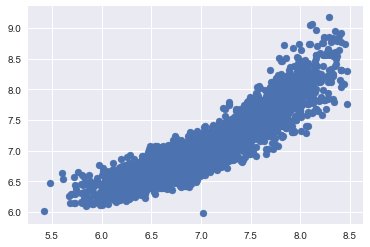

In [394]:
plt.scatter(y_train, pred)
plt.show()

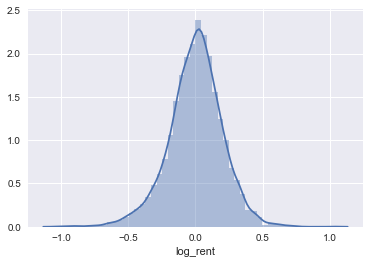

In [395]:
sns.distplot(y_train - pred)

In [396]:
reg.score(X_train, y_train)

0.8418451483531437

In [412]:
from sklearn.model_selection import cross_val_score
np.mean(cross_val_score(reg, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = 3))

-0.15414714534274657

In [366]:
reg_summary = pd.DataFrame(inputs.columns.values, columns = ['Features'])
reg_summary['Weights'] = reg.coef_
reg_summary

Features   Weights
0                      livingSpace  0.350871
1                       newlyConst  0.071650
2                      buildingAge -0.001653
3                          balcony  0.008369
4                       hasKitchen  0.065668
5                           cellar  0.008384
6                             lift  0.022145
7                           garden  0.018547
8                        schufa_yn -0.001418
9                  PersonalInfo_yn -0.011137
10                  incomeProof_yn -0.000936
11                    guarantee_yn  0.002292
12                debtFreeProof_yn  0.008251
13                           ID_yn  0.001730
14         typeOfFlat_ground_floor -0.003871
15        typeOfFlat_half_basement  0.000139
16                 typeOfFlat_loft  0.000969
17           typeOfFlat_maisonette  0.003382
18            typeOfFlat_penthouse  0.010368
19  typeOfFlat_raised_ground_floor -0.002553
20          typeOfFlat_roof_storey  0.008945
21        typeOfFlat_terraced_flat  0.006145
22                 regio3_Buchholz -0.031415
23           regio3_Charlottenburg -0.041116
24           regio3_Friedrichshain -0.013389
25              regio3_Hellersdorf -0.096859
26         regio3_Hohenschönhausen -0.082668
27                regio3_Kreuzberg -0.014232
28                 regio3_Köpenick -0.101091
29              regio3_Lichtenberg -0.080160
30                  regio3_Marzahn -0.098622
31                 regio3_Neukölln -0.061491
32                   regio3_Pankow -0.054313
33          regio3_Prenzlauer Berg -0.011737
34            regio3_Reinickendorf -0.085847
35               regio3_Schöneberg -0.031184
36                  regio3_Spandau -0.105927
37                 regio3_Steglitz -0.057085
38                regio3_Tempelhof -0.062715
39               regio3_Tiergarten -0.030171
40                  regio3_Treptow -0.059446
41                  regio3_Wedding -0.051472
42                regio3_Weißensee -0.057030
43              regio3_Wilmersdorf -0.023491
44               regio3_Zehlendorf -0.034217

Then benchmark variable for regio3 was 'Mitte' while the benchmark variable for apartmentType was 'apartment'

From the weights table above we can see that all arears (regio3) have  negative weight, meaning that rants in all of the areas are lower than in Mitte. 

The feature with the biggest weight appears to be 'livingSpace'.

In [406]:
#using stattsmodels
import statsmodels.api as sm
X_sm = sm.add_constant(X)
model = sm.OLS(y,X_sm)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_rent   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     1012.
Date:                Mon, 07 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:02:27   Log-Likelihood:                 1551.3
No. Observations:                8510   AIC:                            -3011.
Df Residuals:                    8464   BIC:                            -2686.
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.0465      0.002   3214.900      0.000       7.042       7.051
x1             0.3508      0.003    139.406      0.000       0.346       0.356
x2             0.0709      0.003     25.370      0.000       0.065       0.076
x3            -0.0018      0.003     -0.571      0.568      -0.008       0.004
x4             0.0080      0.002      3.287      0.001       0.003       0.013
x5             0.0636      0.002     25.431      0.000       0.059       0.068
x6             0.0096      0.002      4.071      0.000       0.005       0.014
x7             0.0250      0.003      9.001      0.000       0.020       0.030
x8             0.0187      0.002      8.004      0.000       0.014       0.023
x9            -0.0052      0.004     -1.240      0.215      -0.014       0.003
x10           -0.0104      0.003     -3.721      0.000      -0.016      -0.005
x11           -0.0009      0.004     -0.197      0.844      -0.009       0.008
x12            0.0012      0.002      0.545      0.585      -0.003       0.006
x13            0.0080      0.003      2.923      0.003       0.003       0.013
x14            0.0013      0.003      0.486      0.627      -0.004       0.007
x15           -0.0038      0.002     -1.661      0.097      -0.008       0.001
x16           -0.0043      0.002     -1.927      0.054      -0.009    7.26e-05
x17            0.0011      0.002      0.521      0.603      -0.003       0.005
x18            0.0029      0.002      1.252      0.211      -0.002       0.007
x19            0.0097      0.002      4.286      0.000       0.005       0.014
x20           -0.0022      0.002     -0.990      0.322      -0.007       0.002
x21            0.0087      0.002      3.784      0.000       0.004       0.013
x22            0.0075      0.002      3.350      0.001       0.003       0.012
x23           -0.0315      0.002    -13.536      0.000      -0.036      -0.027
x24           -0.0426      0.003    -14.249      0.000      -0.048      -0.037
x25           -0.0146      0.003     -5.205      0.000      -0.020      -0.009
x26           -0.0978      0.003    -35.223      0.000      -0.103      -0.092
x27           -0.0820      0.003    -31.887      0.000      -0.087      -0.077
x28           -0.0150      0.003     -5.767      0.000      -0.020      -0.010
x29           -0.1037      0.003    -33.823      0.000      -0.110      -0.098
x30           -0.0815      0.003    -29.373      0.000      -0.087      -0.076
x31           -0.1005      0.003    -37.759      0.000      -0.106      -0.095
x32           -0.0626      0.003    -21.417      0.000      -0.068      -0.057
x33           -0.0541      0.003    -20.516      0.000      -0.059      -0.049
x34           -0.0112      0.003     -4.060      0.000      -0.017      -0.006
x35           -0.0871      0.003    -29.302      0.000      -0.093      -0.081
x3

## Testing

In [367]:
y_hat_test = reg.predict(X_test)

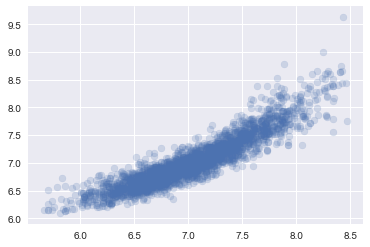

In [368]:
plt.scatter(y_test,y_hat_test, alpha = 0.2)
plt.show()

In [369]:
df_pred = pd.DataFrame(y_hat_test, columns=['Prediction'])
df_pred.head()

Prediction
0    7.639522
1    7.870567
2    6.838529
3    6.624304
4    6.337631

In [370]:
# Undo log transformation to get predctions in €
df_pred = pd.DataFrame(np.exp(y_hat_test), columns=['Prediction'])
df_pred.head()

Prediction
0  2078.750922
1  2619.049393
2   933.115097
3   753.179715
4   565.455302

In [378]:
df_pred['Target'] = (np.exp(y_test).reset_index(drop = True))
df_pred.head()

Prediction   Target     Residual      Diff [%]
0  2078.750922  1871.50 -2071.216426  27489.782413
1  2619.049393  2932.17 -2611.065895  32705.787382
2   933.115097  1015.00  -926.192453  13379.172290
3   753.179715   859.00  -746.423946  11048.689712
4   565.455302   367.00  -559.549940   9475.286264

In [379]:
df_pred['Residual'] = df_pred['Target'] - df_pred['Prediction']

In [380]:
df_pred['Diff [%]'] = np.absolute(df_pred['Residual']/df_pred['Target'] * 100)

In [381]:
df_pred.describe()

Prediction       Target      Residual     Diff [%]
count   2553.000000  2553.000000   2553.000000  2553.000000
mean    1293.221320  1300.285817      7.064497    15.757183
std      805.277278   717.674868    398.998588    15.174118
min      443.526995   290.080000 -10562.683749     0.010115
25%      814.898510   792.000000   -117.998053     5.695019
50%     1052.679465  1100.000000      6.957188    12.167200
75%     1504.399522  1640.000000    143.211276    21.265569
max    15166.803749  4747.600000   2418.776631   229.418081

## Regression Evaluation Metrics
**Root Mean Squared Error** (RMSE)

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

In [382]:
print('RMSE:',
      np.sqrt(metrics.mean_squared_error(df_pred['Target'],
                                                  df_pred['Prediction'])))

RMSE: 398.982985013665


In [399]:
y_true = df_pred['Target']
y_pred = df_pred['Prediction']

rmspe = (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))) * 100

print(f'The root mean squared precent error is: \n{round((rmspe),2)}%')

The root mean squared precent error is: 
21.87%


In [387]:
pd.options.display.max_rows = 2000
df_pred.sort_values(by = ['Diff [%]'], ascending=False).head(300)

Prediction   Target      Residual    Diff [%]
535   15166.803749  4604.12 -10562.683749  229.418081
2165   6495.748616  2650.00  -3845.748616  145.122589
1934    831.346382   341.80   -489.546382  143.225975
1735    672.016071   300.00   -372.016071  124.005357
761     704.691188   327.05   -377.641188  115.468946
363    4404.292316  2069.00  -2335.292316  112.870581
462    8060.335600  3835.00  -4225.335600  110.178243
15      718.103125   352.04   -366.063125  103.983390
283    5086.571029  2498.00  -2588.571029  103.625742
2086   4368.615688  2280.00  -2088.615688   91.605951
487     723.768397   387.28   -336.488397   86.885044
1323    692.596300   374.85   -317.746300   84.766253
1856    881.720200   480.00   -401.720200   83.691708
627     869.036378   475.20   -393.836378   82.878026
2458   1225.709725   673.90   -551.809725   81.883028
590     800.033484   442.00   -358.033484   81.003051
638     999.216948   553.38   -445.836948   80.566148
1339    878.517366   490.00   -388.517366   79.289258
827     760.786015   430.00   -330.786015   76.926980
441     550.548674   311.24   -239.308674   76.888791
2135    732.456951   416.00   -316.456951   76.071382
2053   3435.138310  1955.00  -1480.138310   75.710399
1571   4389.071569  2499.00  -1890.071569   75.633116
1564    517.814849   299.96   -217.854849   72.627967
468    3433.003758  1991.60  -1441.403758   72.374159
1907    802.463715   468.76   -333.703715   71.188607
490    1308.415873   765.31   -543.105873   70.965474
446    3622.418233  2150.00  -1472.418233   68.484569
955     566.417443   337.76   -228.657443   67.698201
204    1424.616613   855.07   -569.546613   66.608186
1991   3940.874816  2397.50  -1543.374816   64.374341
1252   3186.039506  1943.00  -1243.039506   63.975271
2280   1306.208985   800.00   -506.208985   63.276123
1618    873.970669   538.00   -335.970669   62.448080
1613   4195.426957  2583.00  -1612.426957   62.424582
1052   1017.598368   629.00   -388.598368   61.780345
174    1182.376866   733.54   -448.836866   61.187783
330     466.588293   290.08   -176.508293   60.848143
931     831.737584   518.24   -313.497584   60.492742
2434    615.580810   384.17   -231.410810   60.236565
1717    800.353517   499.69   -300.663517   60.170009
1554   4941.328370  3098.00  -1843.328370   59.500593
891     647.513282   406.38   -241.133282   59.336897
663    2171.499621  1364.62   -806.879621   59.128521
975     752.137796   473.00   -279.137796   59.014333
1507   5482.656739  3450.00  -2032.656739   58.917587
2467    931.617626   586.67   -344.947626   58.797557
1896    840.829427   530.00   -310.829427   58.647062
1833    944.297846   596.78   -347.517846   58.232154
2279   1106.332866   699.20   -407.132866   58.228385
1902   5693.685785  3600.00  -2093.685785   58.157938
1659    695.896637   440.39   -255.506637   58.018265
75      832.814524   530.00   -302.814524   57.134816
126    1250.668915   796.00   -454.668915   57.119210
870     895.463845   570.00   -325.463845   57.098920
1756    497.459918   317.00   -180.459918   56.927419
1134    763.542608   490.00   -273.542608   55.825022
2166    632.461385   406.50   -225.961385   55.587057
797    4122.902875  2650.00  -1472.902875   55.581241
2394   1072.043376   690.00   -382.043376   55.368605
2314    465.932647   300.11   -165.822647   55.253956
241    3458.043311  2228.00  -1230.043311   55.208407
634     550.548674   354.96   -195.588674   55.101610
1464    465.932647   300.94   -164.992647   54.825761
1779   1080.069904   699.00   -381.069904   54.516438
428    1918.806340  4200.00   2281.193660   54.314135
4       565.455302   367.00   -198.455302   54.075014
1431    640.444178   416.38   -224.064178   53.812426
1619    670.433180   436.19   -234.243180   53.702098
947     634.112133   414.39   -219.722133   53.023030
491     765.021621   500.00   -265.021621   53.004324
2049    770.427732   505.00   -265.427732   52.559947
1459   1512.517577  3144.00   1631.482423   51.891935
654    1102.

The model tends to overestimate the rent price. This could mean that we are missing some important features that were removed during data cleaning. The model still needs some fine tuning and experementing to find the best predictive features, however, an R² value of 0.85 and a RMSE% of 22% is still relativily good seeing that this project was made purely to help me in my apartment search. 

In [411]:
#lasso regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
lm_l = Lasso()
np.mean(cross_val_score(lm_l, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = 3))

-0.4198290025721963

In [433]:
error = []
alpha = []
for i in range(1,200):
    alpha.append(i/100000)
    lml = Lasso(alpha= (i/100000))
    error.append(np.mean(cross_val_score(lml, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = 3)))

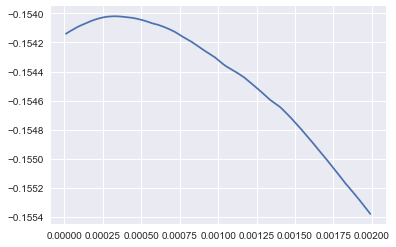

In [434]:
plt.plot(alpha, error)

In [435]:
err = tuple(zip(alpha, error))
df_err = pd.DataFrame(err, columns = ['alpha', 'error'])
df_err[df_err['error'] == df_err['error'].max()]

alpha    error
32  0.00033 -0.15402

In [ ]:
# Random forest